In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import inv, det, cholesky

# Gaussian Process- Task 1

## Read Data

$X : 34 \times 1$ <br>
$y : 34 \times 1$ <br>

In [2]:
def load_data(path):
    x=[]
    y=[]
    for line in open(path):
        point = line.split(' ')
        x.append(float(point[0]))
        y.append(float(point[1]))
    X = np.array(x, dtype=np.float64).reshape(-1, 1)
    y = np.array(y, dtype=np.float64).reshape(-1, 1)

    return X, y

## Kernel Function

Rational Quadratic Kernel
$k(x_{a},x_{b}) = \sigma^{2}(1+\frac{||x_{a}-x_{b}||^{2}}{2\alpha l^{2}})^{-\alpha}$<br>
$\sigma^{2}$ : the overall variance.<br>
$l$ : the length scale. <br>
$\alpha$ : the scale-mixture ( >0).

In [3]:
def k(xa, xb, alpha, sigma, length_scale):
    xa = xa.reshape(-1, 1)
    xb = xb.reshape(1, -1)
    return sigma * (1 + np.power(xa - xb, 2) / (2 * alpha * length_scale ** 2)) ** (-alpha)

## Prediction

$G$ therefore if we want to predict the distribution of new $f*$, we just need to compute the covaraince matrix of $G$, then cut $G $ on $f^{*}$ to see the condition distribution thus achieve prediction. <br>
$C(x_{n},x_{m})=k(x_{n},x_{m})+\beta ^{-1} \delta _{nm}$

$\mu (x^{*}) = k(x,x^{*})^{T}C^{-1}y \\ \sigma^{2}(x) = k^{*} - k(x,x^{*})^{T}C^{-1}k(x,x^{*})\\k^{*} = k(x^{*},x^{*})+\beta^{-1}$

In [4]:
def predict(X_star, X, y, C, alpha, beta, sigma, length_scale):
    
    k_star = k(X_star, X_star, alpha, sigma, length_scale) + beta**(-1)
    k_of_x_x_star = k(X, X_star, alpha, sigma, length_scale)
    C_inv = np.linalg.inv(C)
    mean = k_of_x_x_star.T@C_inv@y
    variance = k_star - k_of_x_x_star.T@C_inv@k_of_x_x_star
    
    return mean, variance

## Negative log-Likelihood

$\ln p(y|\theta) = -\frac{1}{2}\ln|C_{\theta|}-\frac{1}{2}y^{T}C^{-1}_{\theta}y-\frac{N}{2}\ln(2\pi)$

In [5]:
def objective_function(theta, X, y, beta):
    theta = theta.ravel()
    sigma = theta[0]
    alpha = theta[1]
    length_scale = theta[2]
    
    delta = np.identity(len(X), dtype=np.float64)
    C = k(X, X, alpha, sigma, length_scale) + beta**(-1) * delta
    C_inv = np.linalg.inv(C)
    likelihood = ((1/2)*np.log(np.linalg.det(C)))+((1/2)*y.T@C_inv@y)+((1/2)*(len(X))*np.log(2*np.pi))
    
    return likelihood.ravel()

In [6]:
X, y = load_data('data\ML_HW05\data\input.data')
alpha = 1
beta = 5
sigma = 1
length_scale = 1

In [7]:
opt = minimize(objective_function, [sigma, alpha, length_scale], 
                    bounds=((1e-8, 1e6), (1e-8, 1e6), (1e-8, 1e6)), 
                    args=(X, y, beta))
opt_sigma = opt.x[0]
opt_alpha = opt.x[1]
opt_length_scale = opt.x[2]

print('after optimization')
print(f'sigma : {opt_sigma} , alpha : {opt_alpha} , length_scale : {opt_length_scale}')

after optimization
sigma : 1.7206633833720293 , alpha : 306.49608574602564 , length_scale : 3.3221506784275


In [8]:
delta = np.identity(len(X), dtype=np.float64)
C = k(X, X, opt_alpha, opt_sigma, opt_length_scale) + beta**(-1) * delta

In [9]:
line_test_x = np.linspace(-60, 60, num=500)
mean, variance = predict(line_test_x, X, y, C, opt_alpha, beta, opt_sigma, opt_length_scale)
mean=mean.reshape(-1)
variance = np.sqrt(np.diag(variance))

In [10]:
def visualization(X, y, line_test_x, mean, variance):
    plt.plot(line_test_x, mean)
    plt.fill_between(line_test_x, mean+1.96*variance, mean-1.96*variance, facecolor='salmon')
    plt.xlim(-60,60)
    plt.plot(X, y, 'bo')
    plt.title('result')
    plt.show

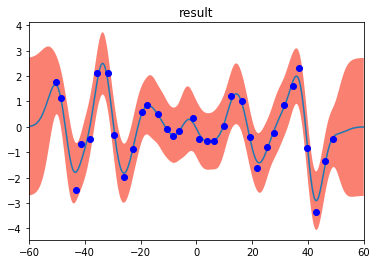

In [11]:
visualization(X, y, line_test_x, mean, variance)